In [14]:
import os, sys
sys.path.append(os.path.join('/home/ring/sumo-svn/', 'tools'))
import traci
import traci.constants as tc
import numpy as np
from sumolib import checkBinary
import datetime
import matplotlib
import matplotlib.pyplot as plt
import torch

In [2]:
#reset the environment
def reset():
    sumoBinary = checkBinary('sumo-gui')
    traci.start([sumoBinary, "-c", "map_grid_lock_add2TL_copy.sumocfg",
                             "--tripinfo-output", "tripinfo.xml", '--start','true','--quit-on-end','true','--time-to-teleport','-1'])

In [3]:
id = {'virtual' : '270329335' ,'KasemRat': 'cluster_272448137_272555800_272555808_7660045934_7710268409'}
detecters = {'QA' : ['156261350#0'], 'QB' : ['-453962283#3'], 'QC' : ['459551209#0', '459551209#3'], 'QD' : ['27702347#0', '27702347#4', '27702347#6']}

In [4]:
import sumolib
import lxml.etree as ET
def get_edge_id(POI):
    root = ET.Element('additionals')
    net = sumolib.net.readNet('map_grid_lock_add2TL_copy_newTLS.net.xml')
    output = []
    for key in POI:
        edgeID = net.getEdge(key)
        numOfLane = edgeID.getLaneNumber()
        for lane_index in range(numOfLane):
            output.append(key+'_'+str(lane_index))
    return output    

In [9]:
def get_state():
    occupancy = []
    for key in ['QA', 'QB', 'QC', 'QD']:
        occupancy.append(sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(detecters[key])])/len(get_edge_id(detecters[key])))
    current_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
    for i in current_phase:
        current_phase_binary = [0, 0, 0]
        current_phase_binary[int(i//2)] = 1
        occupancy+= current_phase_binary
    return occupancy

In [10]:
def initial(max_occupancy):
    occupancy = state[0:4]
    print(occupancy)
    s1 = state[4:7]
    s2 = state[7:9]
    if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
        print(occupancy)
        print('set0')
        traci.trafficlight.setPhase(id['virtual'], 2)
    elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[0] != 1:
        traci.trafficlight.setPhase(id['KasemRat'], 0)
    elif occupancy[2] >= max_occupancy:
        print(occupancy)
        print('set2')
        traci.trafficlight.setPhase(id['KasemRat'], 2)
    else:
        traci.trafficlight.setPhase(id['virtual'], 0)
    for i in range(5):
        traci.simulationStep()
    reward = -sum(get_state())    
    return reward

In [18]:
reward_memory = []
def plot_durations():
    print('show')
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(reward_memory, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [19]:
traci.close()

[0.0, 0.0, 0.0, 0.0]
show


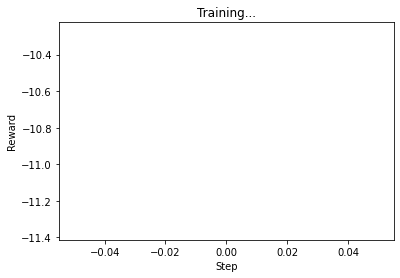

[0.0, 0.0, 8.81831169220976, 0.0]
show


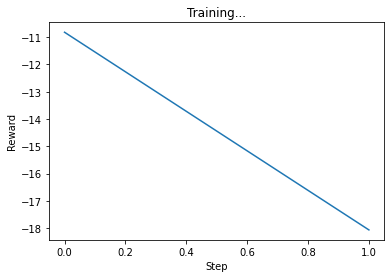

[0.0, 0.0, 16.067782894979423, 0.0]
show


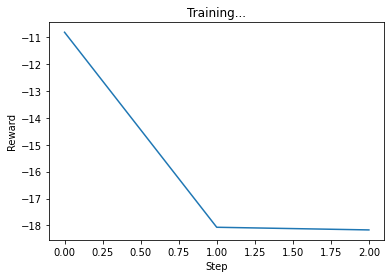

[0.0, 0.0, 16.166341431316717, 0.0]
show


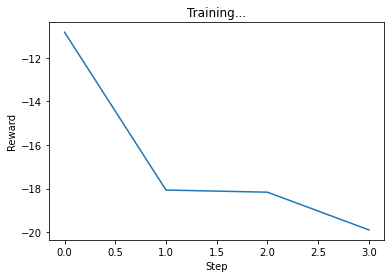

[0.0, 0.0, 17.899592152070632, 0.0]
show


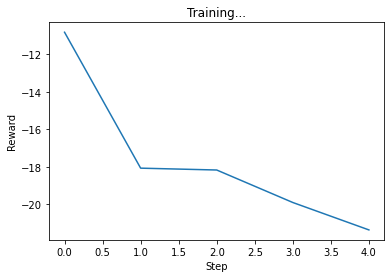

[1.8350440624129567, 0.0, 17.52676374436763, 0.0]
show


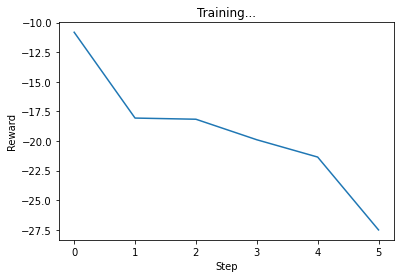

[4.279891304347826, 0.0, 21.235858225237195, 0.0]
show


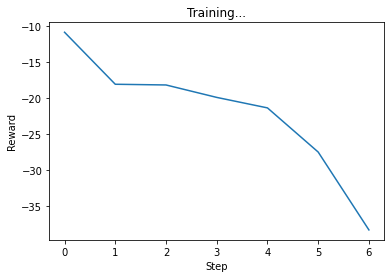

[7.133152173913045, 6.439473134016308, 22.796659128910978, 0.0]
show


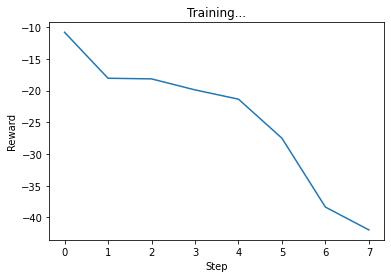

[8.559782608695654, 11.409742513476138, 19.994779610745667, 0.0]
show


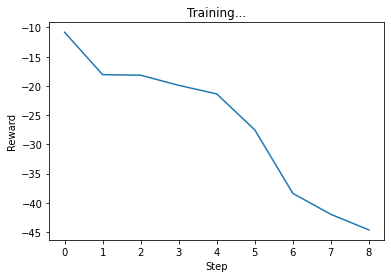

[9.986413043478262, 14.019908683823, 18.622492776693996, 0.0]


In [ ]:
#episode = 0
reset()
traci.simulationStep()
for seconds in range(1000):
    state = get_state()
    reward = initial(50)
    reward_memory.append(reward)
    plot_durations()
    
traci.close()